In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import healpy as hp
import tqdm


sys.path.append('../pipeline_scripts/')
from pipeline_main import serialize_dictionary, pipeline
from plotting_setup import *


In [2]:
data = pipeline(snap = 223, run = 'sink13fmr05', sink_id=13)

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:12<00:00, 326.20it/s]


In [3]:
map_data = serialize_dictionary(filename = 'sink13fmr05_accretion_maps.pkl', store = False)

In [4]:
nside = 45
npix = hp.nside2npix(nside)
shell_r = 50 / data.au_length
Lat = np.unique(hp.pix2ang(nside, np.arange(npix))[0]) - np.pi/2

time = map_data['time']
t_new = time[time != 0].copy()

In [5]:
infall = np.zeros((len(time), len(Lat) - 1))
outflow = np.zeros_like(infall)
pct_in = np.zeros_like(time)
pct = np.array([25, 50, 75, 100])
area_data = np.zeros((len(pct), len(time)))

cum_lat = np.zeros_like(area_data)
sec_lat = np.zeros_like(area_data)

for t in tqdm.tqdm(range(len(time))):
    map = map_data['maps'][t]
    bool_pos = map > 0; bool_neg = map < 0
    inflow_pixels = map[bool_pos]
    outflow_pixels = map[bool_neg]

    Lat_in, _ = hp.pix2ang(nside, np.arange(npix)[bool_pos]) 
    Lat_out, _ = hp.pix2ang(nside, np.arange(npix)[bool_neg]) 
    infall_index = np.argsort(inflow_pixels)[::-1]

    pct_in[t] = len(Lat_in) / npix * 100

    cell_area = hp.nside2pixarea(nside) * shell_r**2

    sphere_area = cell_area * npix 

    x = np.arange(len(inflow_pixels)) * cell_area / sphere_area * 100
    y = np.cumsum(inflow_pixels[infall_index]) / np.sum(inflow_pixels) * 100

    if len(y) == 0: continue

    indicies = [np.argmin(abs(y - p)) for p in pct]    
    area_data[:,t] = x[indicies]

    cum_lat[:,t] = [np.average(Lat_in[infall_index][:j], weights=inflow_pixels[infall_index][:j]) for j in indicies]

    k0 = 0
    for i, k in enumerate(indicies):
        sec_lat[i,t] = np.average(Lat_in[infall_index][k0:k], weights=inflow_pixels[infall_index][k0:k])
        k0 = k.copy()


100%|██████████| 289/289 [00:00<00:00, 456.80it/s]


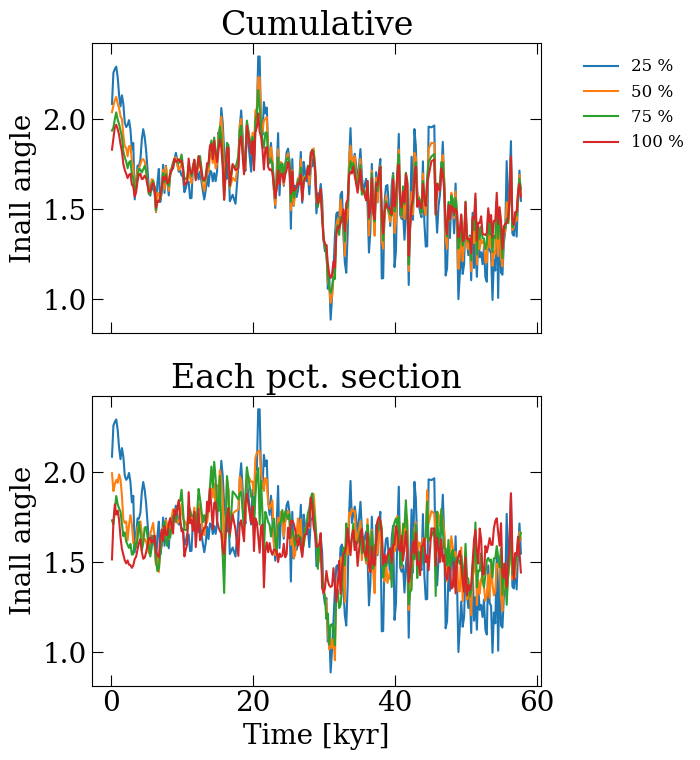

In [6]:
fig, ax = plt.subplots(2, 1, figsize = (8,8), sharex = True)

k = 1e-3
axs = ax[0]
for i, p in enumerate(pct):
    axs.plot(t_new*k, cum_lat[i,:][time != 0], label = f'{p} %')
    axs.set(title = 'Cumulative', ylabel = 'Inall angle')


axs.legend(loc = 'upper right', bbox_to_anchor = (1.35,1), frameon = False, prop = {'size':12})

axs = ax[1]
for i, p in enumerate(pct):
    axs.plot(t_new*k, sec_lat[i,:][time != 0])
    axs.set(title = 'Each pct. section', ylabel = 'Inall angle', xlabel = 'Time [kyr]')

plt.tight_layout()

In [7]:
flux = {
    'Inflow': pct_in[time != 0],
    'Outflow': 100 - pct_in[time != 0]}

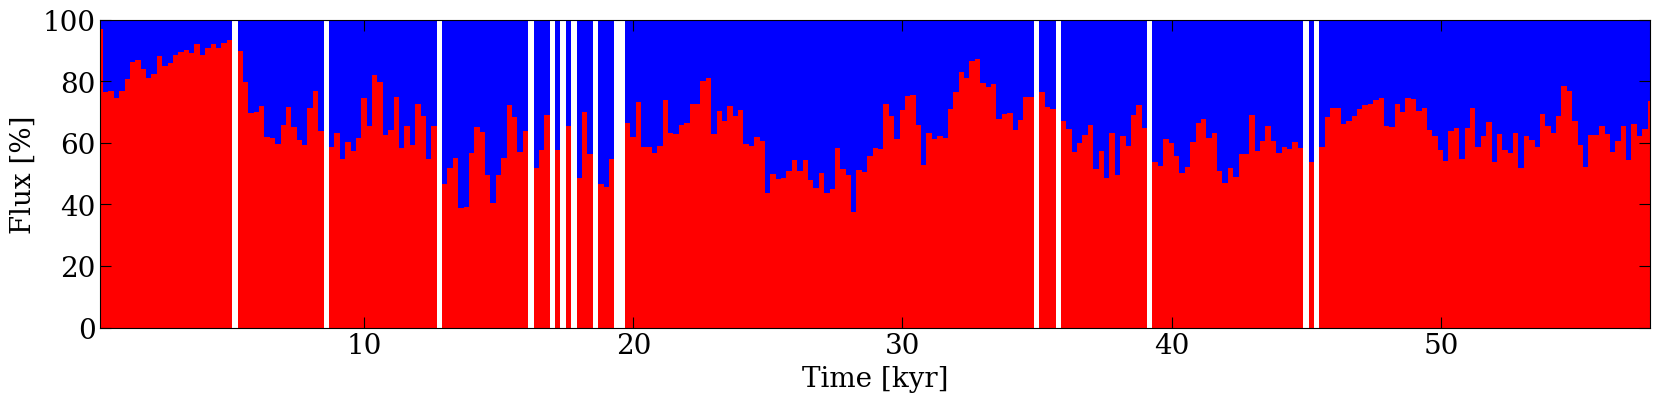

In [8]:
fig, axs = plt.subplots(figsize = (20,4))


bottom = np.zeros_like(t)


axs.bar(t_new*1e-3, flux['Inflow'], width =0.2, align='center', color = 'red')
axs.bar(t_new*1e-3, flux['Outflow'], width =0.2, align='center', bottom=flux['Inflow'], color = 'blue')

axs.set(xlim = (t_new[0]*1e-3,t_new[-1]*1e-3),ylim = (0,100), ylabel = 'Flux [%]', xlabel = 'Time [kyr]')

plt.show()

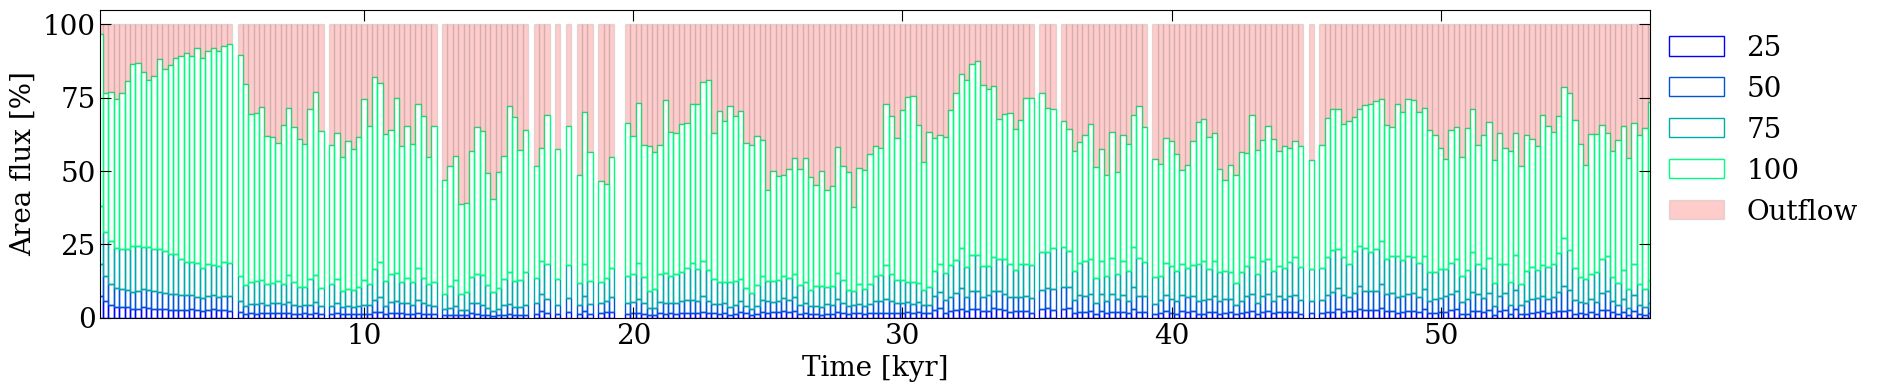

In [9]:
fig, axs = plt.subplots(figsize = (20,4))
colors = plt.cm.winter(np.linspace(0,1, len(pct)))


bottom = np.zeros_like(t_new)
to_bar = np.vstack((area_data[0,:], np.diff(area_data, axis = 0)))

for i, p in enumerate(pct):
    axs.bar(t_new*1e-3, to_bar[i,:][time != 0], width = 0.2, align='center', label = p, bottom=bottom, fill=False, edgecolor = colors[i])
    bottom += to_bar[i,:][time != 0]


#axs.bar(t*1e-3, flux['Inflow'], width =0.2, align='center', color = 'red')
axs.bar(t_new*1e-3, flux['Outflow'], width =0.2, align='center', bottom=area_data[-1,:][time != 0], label = 'Outflow', color = 'red', alpha = 0.2, edgecolor = 'grey')

axs.set(xlim = (t_new[0]*1e-3,t_new[-1]*1e-3), ylabel = 'Area flux [%]', xlabel = 'Time [kyr]')

plt.legend(loc = 'upper right', bbox_to_anchor = (1.15,1), frameon = False)

In [10]:
bins = np.unique(hp.pix2ang(nside, np.arange(npix))[0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


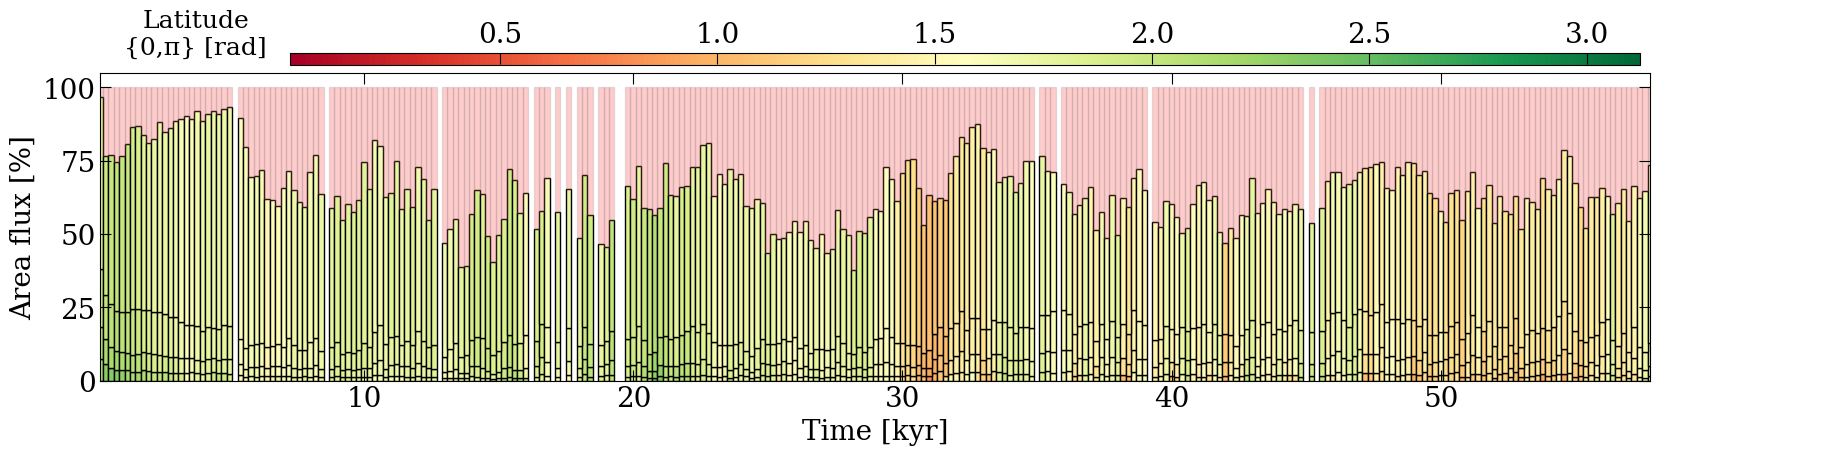

In [11]:
fig, axs = plt.subplots(figsize = (20,4))


lat_colors = plt.cm.RdYlGn(np.linspace(0,1, len(bins)))

bottom = np.zeros_like(t_new)
to_bar = np.vstack((area_data[0,:], np.diff(area_data, axis = 0)))

cuml = cum_lat[:,time != 0]
for i, p in enumerate(pct):
    bar_color = np.array([np.argmin(abs(cuml[i,t] - bins)) for t in range(len(time[time != 0]))]).copy()
    axs.bar(t_new*1e-3, to_bar[i,:][time != 0], width = 0.2, align='center', label = p, bottom=bottom, fill=True, edgecolor = 'black', color = lat_colors[bar_color])
    bottom += to_bar[i,:][time != 0]


#axs.bar(t*1e-3, flux['Inflow'], width =0.2, align='center', color = 'red')
axs.bar(t_new*1e-3, flux['Outflow'], width =0.2, align='center', bottom=area_data[-1,:][time != 0], label = 'Outflow', color = 'red', alpha = 0.2, edgecolor = 'grey')

axs.set(xlim = (t_new[0]*1e-3,t_new[-1]*1e-3), ylabel = 'Area flux [%]', xlabel = 'Time [kyr]')

cbaxes = fig.add_axes([0.22, 0.9, 0.675, 0.03])
norm = plt.Normalize(vmin=min(bins), vmax=max(bins)) 
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=norm); sm.set_array([])

cbar = fig.colorbar(sm, cax=cbaxes, orientation='horizontal')  # Create the colorbar
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('Latitude\n{0,π} [rad]', labelpad = -40, x = -0.07, rotation = 0, fontsize = 18)


plt.legend(loc = 'upper right', bbox_to_anchor = (1.15,1), frameon = False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


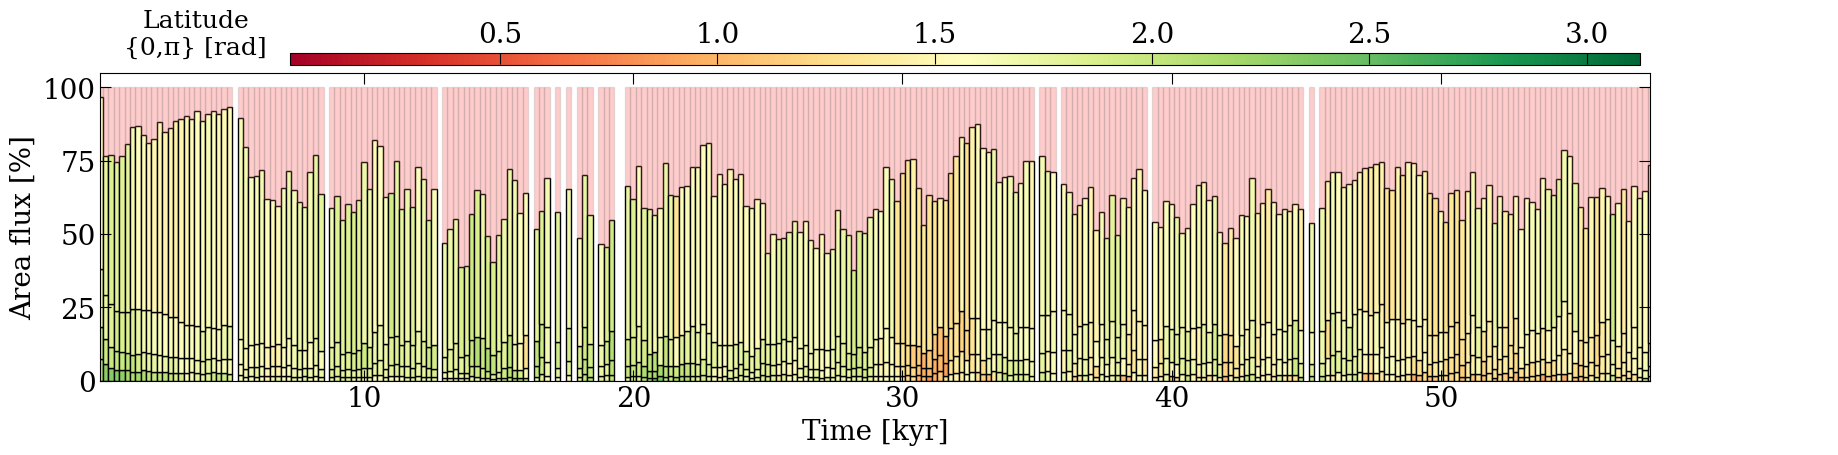

In [12]:
fig, axs = plt.subplots(figsize = (20,4))



lat_colors = plt.cm.RdYlGn(np.linspace(0,1, len(bins)))

bottom = np.zeros_like(t_new)
to_bar = np.vstack((area_data[0,:], np.diff(area_data, axis = 0)))


sec = sec_lat[:, time != 0]
for i, p in enumerate(pct):
    bar_color = np.array([np.argmin(abs(sec[i,t] - bins)) for t in range(len(time[time != 0]))]).copy()
    axs.bar(t_new*1e-3, to_bar[i,:][time != 0], width = 0.2, align='center', label = p, bottom=bottom, fill=True, edgecolor = 'black', color = lat_colors[bar_color])
    bottom += to_bar[i,:][time != 0]

#axs.bar(t*1e-3, flux['Inflow'], width =0.2, align='center', color = 'red')
axs.bar(t_new*1e-3, flux['Outflow'], width =0.2, align='center', bottom=area_data[-1,:][time != 0], label = 'Outflow', color = 'red', alpha = 0.2, edgecolor = 'grey')

axs.set(xlim = (t_new[0]*1e-3,t_new[-1]*1e-3), ylabel = 'Area flux [%]', xlabel = 'Time [kyr]')

cbaxes = fig.add_axes([0.22, 0.9, 0.675, 0.03])
norm = plt.Normalize(vmin=min(bins), vmax=max(bins)) 
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=norm); sm.set_array([])

cbar = fig.colorbar(sm, cax=cbaxes, orientation='horizontal')  # Create the colorbar
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('Latitude\n{0,π} [rad]', labelpad = -40, x = -0.07, rotation = 0, fontsize = 18)


plt.legend(loc = 'upper right', bbox_to_anchor = (1.15,1), frameon = False)

In [13]:
sec_lat[0,:30], bins[bar_color][:30]

(array([2.08633332, 2.25962559, 2.27976747, 2.29319369, 2.23662585,
        2.13581566, 2.07271547, 2.13402658, 2.08657355, 1.98265296,
        1.95777539, 1.96894904, 1.99614299, 1.94483573, 1.83282033,
        1.86876132, 1.55572047, 1.6518018 , 1.7437445 , 1.74250154,
        1.77465187, 1.8881565 , 1.94573572, 1.90404104, 1.83113754,
        0.        , 1.61742659, 1.57614251, 1.64804108, 1.60918463]),
 array([1.51150233, 1.71949182, 1.82538964, 1.76459985, 1.77972032,
        1.73448935, 1.64493831, 1.57079633, 1.54116236, 1.51150233,
        1.49665434, 1.51150233, 1.48178996, 1.48178996, 1.46690584,
        1.48178996, 1.51150233, 1.52633724, 1.57079633, 1.60043029,
        1.63009032, 1.55598097, 1.52633724, 1.52633724, 1.55598097,
        1.63009032, 1.63009032, 1.61525542, 1.61525542, 1.64493831]))